In [1]:
#all imports
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [2]:
#variables declared here:
pix_edge_l = 30 #microns
pix_half_l = pix_edge_l / 2
num_pix_x = 20
num_pix_y = 20
e_per_photon = 1500 #electrons
subpix_edge_l = 1 #microns #this number just determines the img quality 
#subpix size tells the program how exact we want our calculations. how many pieces of the pixel are we accounting for 
#similar to integration by parts
e_cloud = 50 #microns diameter
gain = 2 #electrons/DN

In [3]:
#index:
#pix = pixel
#e = electron
#l = length
#num = number (of)
#pct = percent
#arr = array
#dist = distance

In [4]:
#array for edge values
#edge_pix_arr (+1)
#calc edges for big array and subarray

In [5]:
#defining initial array representation of detector
detector_arr = np.zeros((num_pix_x, num_pix_y))
detector_arr_x = np.arange(num_pix_x) * pix_edge_l + pix_half_l
detector_arr_y = np.arange(num_pix_y) * pix_edge_l + pix_half_l
cen_x = np.arange(num_pix_x) * pix_edge_l + pix_half_l
cen_y = np.arange(num_pix_y) * pix_edge_l + pix_half_l
edge_x = np.arange(num_pix_x + 1) * pix_edge_l
edge_y = np.arange(num_pix_y + 1) * pix_edge_l

In [10]:
#finding random x & y point
#if its too close to val find a different
#go from rand # to putting photon in array and LOOP 2 or 5 
#this is in the loop
photon_x = random.random() * pix_edge_l * num_pix_x #microns
photon_y = random.random() * pix_edge_l * num_pix_y #microns
photon_z = int(e_cloud/2) #microns
print("photon hit at [x,y,z] = [" + str(photon_x) + ", " + str(photon_y) + ", " + str(photon_z) + "] microns")

photon hit at [x,y,z] = [807.0697652783335, 432.69804767249997, 25] microns


In [11]:
#finding closest pixel to random x & y
#this inside loop
closest_pix_x = (np.where(np.abs(detector_arr_x - photon_x) == np.min(np.abs(detector_arr_x - photon_x))))[0]
closest_pix_x = closest_pix_x[0]
closest_pix_x_microns = closest_pix_x * pix_edge_l + pix_half_l
closest_pix_y = (np.where(np.abs(detector_arr_y - photon_y) == np.min(np.abs(detector_arr_y - photon_y))))[0]
closest_pix_y = closest_pix_y[0]
closest_pix_y_microns = closest_pix_y * pix_edge_l + pix_half_l
closest_pix_arr = [closest_pix_x, closest_pix_y]
closest_pix_microns = [closest_pix_x_microns, closest_pix_y_microns]
print("closest pixel to sphere: " + str(closest_pix_arr))
print("closest pixel's center in microns: " + str(closest_pix_microns))

closest pixel to sphere: [26, 14]
closest pixel's center in microns: [795.0, 435.0]


In [12]:
#basically max num of pixels needed use % and make solution odd
#num_pix_img wants to be odd and calculated based on diameter of cloud and size of pixel
#we used += 3 and 2 to make sure there was an extra "layer" of pixels surrounding in case of accidental overlap
num_pix_img = math.ceil(e_cloud / pix_edge_l)
if num_pix_img % 2 == 0:
    num_pix_img += 3
else:
    num_pix_img += 2
print(num_pix_img)

5


In [13]:
#setting up for numerical integration
#subpix_edge_l is declared in the variable section [ln 2]
#why do we need -1)/2)?
start_pix = int((num_pix_img - 1) / 2)

#num_subpix is the number in x & y (rows and columns) they are always equal because the photon will always be a circle
num_subpix = num_subpix_x = num_subpix_y = round((pix_edge_l * num_pix_img) / subpix_edge_l)
num_subpix_z = photon_z * 2 #*** will need to be fixed/removed later

subpix_arr = np.zeros((num_subpix_x, num_subpix_y, num_subpix_z))
#check if over the edge when we loop over photons
#why is this the proper math?
#ask where the 3D photon is defined/ generated? why is it sometimes messed up??
subpix_x_cen = np.arange(num_subpix_x) * subpix_edge_l + (detector_arr_x[closest_pix_x - start_pix] - pix_half_l) + subpix_edge_l
subpix_y_cen = np.arange(num_subpix_y) * subpix_edge_l + (detector_arr_y[closest_pix_y - start_pix] - pix_half_l) + subpix_edge_l  
subpix_z_cen = np.arange(num_subpix_z) * subpix_edge_l

In [14]:
#for loop to find subpix array to plot the magnified part of the detector (where the photon hit)
#integration here (only want to integrate in z)
for i in range(num_subpix_x):
    for j in range(num_subpix_y):
        for k in range(num_subpix_z):
            dist_cen_photon = np.sqrt((subpix_x_cen[i] - photon_x)**2 + \
                                                (subpix_y_cen[j] - photon_y)**2 + \
                                                (subpix_z_cen[k] - photon_z)**2)
#the entire electron will be contained within a pixel if the distance from center of photon is less than half the e_cloud diameter
            if dist_cen_photon < e_cloud / 2:
                subpix_arr[i,j,k] = 1

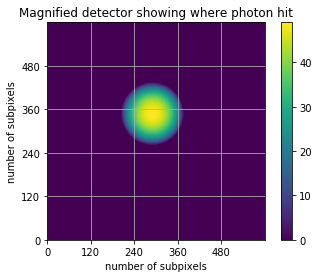

In [42]:
#imgplot is a zoomed in 2D visualization of a 3D photon hitting the sensor
#this cell is making the imshow graph/ image
#img = is the integration
img = np.sum(subpix_arr, axis=2)
imgplot = plt.imshow(img)
plt.grid(True)
plt.axis([0, num_subpix_x, 0, num_subpix_y])
#subpix size tells the program how exact we want our calculations. how many pieces of the pixel are we accounting for
#*** shows 90 as past the boarder. also check the subpix defined edges, why not just full pixels?
plt.title('Magnified detector showing where photon hit')
plt.xlabel('number of subpixels')
plt.ylabel('number of subpixels')
plt.colorbar()
plt.axis(aspect = 'img')
ax = plt.gca()
ax.set_xticks(np.arange(0, num_subpix_x, num_subpix_x / num_pix_img))
ax.set_yticks(np.arange(0, num_subpix_y, num_subpix_y / num_pix_img))
plt.show()
#figure be self explanitory
#add legends etc. 
#voxel = 3D pixel
#add dashed lines to show pixel boarder


In [22]:
np.sum(img)

642713.0

In [23]:
#how to calculate amount in each pixel with varying photon size?
#declared another array, but is that moving backwards? how to make these loops work using variable values
#try: pct_pix_arr and loop it??
#divide the subpix_arr values by num_pix_img
#for value inside subpix_arr/num_pix_img

In [41]:
ii = closest_pix_x
jj = closest_pix_y
#"-1 = start_pix"
#make the range related to the size of graph??
#why is closestpix-startpix the starting point of range? is th
for ii in range(closest_pix_x - start_pix, closest_pix_x + (num_pix_img - start_pix)):
    for jj in range(closest_pix_y - start_pix, closest_pix_y + (num_pix_img - start_pix)):
        left_edge = edge_x[ii]
        #used to be +1 is startpix right var for here? whats best way to make it generic
        right_edge = edge_x[ii + 1] 
        bottom_edge = edge_y[jj]
        top_edge = edge_y[jj + 1] 
        #gives us 1st element to sum over
        #>= <= allows us to account for the pixels landing on the edge
        match_x0 = np.where (subpix_x_cen >= left_edge)[0][0]
        #[0][-1] -1 means take the last numbre of the array
        match_x1 = np.where (subpix_x_cen <= right_edge)[0][-1]
        match_y0 = np.where (subpix_y_cen >= bottom_edge)[0][0]
        match_y1 = np.where (subpix_y_cen <= top_edge)[0][-1]
        this_pct = np.sum(img[match_x0:match_x1, match_y0:match_y1]) / np.sum(img)
        #with more photons continue to += 
        detector_arr[ii, jj] += this_pct * e_per_photon
        print(detector_arr[ii,jj])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
169.10658412075063
1606.0574471031396
39.5542022644633
0.0
0.0
94.427839486676
1073.0886103128457
17.76531671212501
0.0
0.0
0.0
0.0
0.0
0.0


In [38]:
print(edge_x[closest_pix_x])
print(edge_x[closest_pix_x +1])
print(cen_x[closest_pix_x])
print(bottom_edge)
print(top_edge)
print(match_x1)
print(len(subpix_x_cen))
print(subpix_x_cen[30])
print(subpix_x_cen[58])

780
810
795.0
480
510
599
600
727.75
734.75


In [39]:
#LOOP through the different pixels by varying the input
#pct_pix1 = np.sum(img[0:int(pix1), 0:int(pix1)]) / np.sum(img)
#pct_pix2 = np.sum(img[0:int(pix1), int(pix1):int(pix2)]) / np.sum(img)
#pct_pix3 = np.sum(img[0:int(pix1), int(pix2):int(num_subpix)]) / np.sum(img)
#pct_pix4 = np.sum(img[int(pix1):int(pix2), 0:int(pix1)]) / np.sum(img)
#pct_pix5 = np.sum(img[int(pix1):int(pix2), int(pix1):int(pix2)]) / np.sum(img)
#pct_pix6 = np.sum(img[int(pix1):int(pix2), int(pix2):int(num_subpix)]) / np.sum(img)
#pct_pix7 = np.sum(img[int(pix2):int(num_subpix), 0:int(pix1)]) / np.sum(img)
#pct_pix8 = np.sum(img[int(pix2):int(num_subpix), int(pix1):int(pix2)]) / np.sum(img)
#pct_pix9 = np.sum(img[int(pix2):int(num_subpix), int(pix2):int(num_subpix)]) / np.sum(img)

In [40]:
check_tot_e = np.sum(detector_arr)
if (check_tot_e == e_per_photon):
    print('No rounding error. total number of electrons = ' + str(e_per_photon))
else:
    print('***ROUNDING ERROR: total number of electrons is != ' + str(e_per_photon) + ". It is = " + str(check_tot_e))


No rounding error. total number of electrons = 1500


In [ ]:
#range(start val(opt), end val (req)(up to but not including), incriments (opt)(default = 1))
#for pct_pix in range(1, 10):


In [ ]:
#LOOP through this print function?? 
#print("% in first pixel: " + str(pct_pix1 * 100) + "%")
#print("% in second pixel: " + str(pct_pix2 * 100) + "%")
#print("% in third pixel: " + str(pct_pix3 * 100) + "%")
#print("% in fourth pixel: " + str(pct_pix4 * 100) + "%")
#print("% in fifth pixel: " + str(pct_pix5 * 100) + "%")
#print("% in sixth pixel: " + str(pct_pix6 * 100) + "%")
#print("% in seventh pixel: " + str(pct_pix7 * 100) + "%")
#print("% in eigth pixel: " + str(pct_pix8 * 100) + "%")
#print("% in ninth pixel: " + str(pct_pix9 * 100) + "%")

In [ ]:
#detector_arr[closest_pix_x,closest_pix_y] += pct_pix1 * e_per_photon

In [ ]:
#LOOP?
#for e_pix in range(1,10):
    #round(e_per_photon * pct_pix)
#e_pix1 = round(e_per_photon * pct_pix1)
#e_pix2 = round(e_per_photon * pct_pix2)
#e_pix3 = round(e_per_photon * pct_pix3)
#e_pix4 = round(e_per_photon * pct_pix4)
#e_pix5 = round(e_per_photon * pct_pix5)
#e_pix6 = round(e_per_photon * pct_pix6)
#e_pix7 = round(e_per_photon * pct_pix7)
#e_pix8 = round(e_per_photon * pct_pix8)
#e_pix9 = round(e_per_photon * pct_pix9)

In [ ]:
#can make if else statement for this, so you don't have to check the zeros
print('1. ' + str(detector_arr[closest_pix_x - 1, closest_pix_y - 1]))
print('2. ' + str(detector_arr[closest_pix_x, closest_pix_y - 1]))
print('3. ' + str(detector_arr[closest_pix_x + 1, closest_pix_y - 1]))
print('4. ' + str(detector_arr[closest_pix_x - 1, closest_pix_y]))
print('5. ' + str(detector_arr[closest_pix_x, closest_pix_y]))
print('6. ' + str(detector_arr[closest_pix_x + 1, closest_pix_y]))
print('7. ' + str(detector_arr[closest_pix_x - 1, closest_pix_y + 1]))
print('8. ' + str(detector_arr[closest_pix_x, closest_pix_y + 1]))
print('9. ' + str(detector_arr[closest_pix_x + 1, closest_pix_y + 1]))

In [ ]:
detector_arr[closest_pix_x - 1, closest_pix_y - 1] += e_pix1
detector_arr[closest_pix_x, closest_pix_y - 1] += e_pix2
detector_arr[closest_pix_x + 1, closest_pix_y - 1] += e_pix3
detector_arr[closest_pix_x - 1, closest_pix_y] += e_pix4
detector_arr[closest_pix_x, closest_pix_y] += e_pix5
detector_arr[closest_pix_x + 1, closest_pix_y] += e_pix6
detector_arr[closest_pix_x - 1, closest_pix_y + 1] += e_pix7
detector_arr[closest_pix_x, closest_pix_y + 1] += e_pix8
detector_arr[closest_pix_x + 1, closest_pix_y + 1] += e_pix9

In [ ]:
print('1. ' + str(detector_arr[closest_pix_x - 1, closest_pix_y - 1]))
print('2. ' + str(detector_arr[closest_pix_x, closest_pix_y - 1]))
print('3. ' + str(detector_arr[closest_pix_x + 1, closest_pix_y - 1]))
print('4. ' + str(detector_arr[closest_pix_x - 1, closest_pix_y]))
print('5. ' + str(detector_arr[closest_pix_x, closest_pix_y]))
print('6. ' + str(detector_arr[closest_pix_x + 1, closest_pix_y]))
print('7. ' + str(detector_arr[closest_pix_x - 1, closest_pix_y + 1]))
print('8. ' + str(detector_arr[closest_pix_x, closest_pix_y + 1]))
print('9. ' + str(detector_arr[closest_pix_x + 1, closest_pix_y + 1]))

In [21]:
#!!! sometimes this "check" doesnt work: ask if theres a better numpy function to be precise
check_tot_e = np.sum(detector_arr)
if (check_tot_e == e_per_photon):
    print('No rounding error. total number of electrons = ' + str(e_per_photon))
else:
    print('***ROUNDING ERROR: total number of electrons is != ' + str(e_per_photon) + ". It is = " + str(check_tot_e))

***ROUNDING ERROR: total number of electrons is != 1500. It is = 0.0


In [ ]:
#digitize array using np.digitize
#make array values integers
#how would you find the gain if you weren't given it?
#what kind of errors are introduced?
#how many times to measure a single photon to get rid of error?
#numpy.digitize(x, bins, right=False(optional))
#numpy.histogram(a, bins=10, range=None, normed=None, weights=None, density=None)

#assume 2 electrons/DN
#gain = (# of electrons per pixel) / (# of counts per pixel)
#stdev (photons)  =  sqrt(number of photons)

In [ ]:
#here the data in detector_arr is still float it will become integer when digitized below
detector_arr = np.round(detector_arr * (1 / gain))

In [ ]:
#NOTES:
#could you figure out, gain? figure out gain if the # of electrons per photon is known and output is known
#How well would you know it?  

#What kind of errors are introduced by the charge sharing and digitization? 
        # we already have a rounding error before digitization, but after digitizing it can cause errors 
        # because we have less information... we only know which pixels are "on"
#How many times do you need to measure this single photon signal to beat down those errors?

#The gain value is set by the electronics that read out the CCD chip. 
#Gain is expressed in units of electrons per count. 
#For example, a gain of 1.8 e-/count means that the camera produces 1 count for every 1.8 recorded electrons.
#Of course, we cannot split electrons into fractional parts, as in the case for a gain of 1.8 e-/count. 
#What this number means is that 4/5 of the time 1 count is produced from 2 electrons, and 1/5 of the time 1 count is produced from 1 electron. 
#This number is an average conversion ratio, based on changing large numbers of electrons into large numbers of counts.
#Note: This use of the term "gain" is in the opposite sense to the way a circuit designer would use the term since, 
#in electronic design, gain is considered to be an increase in the number of output units compared with the number of input units.

In [ ]:
imgplot = plt.imshow(detector_arr[[closest_pix_x[0] - 5 : closest_pix_x[0] + 5], [closest_pix_y[0] - 5 : closest_pix_y[0] + 5]])

In [ ]:
print(np.max(detector_arr))

In [ ]:
print(np.sum(detector_arr))

In [ ]:
if (np.sum(detector_arr) == 750):
    print('no problem')
else:
    print('error: sum of detector did not result in expected value')